In [6]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from datetime import datetime, timedelta, timezone

In [8]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 999
seed_everything(SEED)

In [9]:
def get_BJ_time():
    # 拿到UTC时间，并强制设置时区为UTC+0:00
    utc_dt = datetime.utcnow().replace(tzinfo=timezone.utc)
    # astimezone()将转换时区为北京时间
    bj_dt = utc_dt.astimezone(timezone(timedelta(hours=8)))
    current_time = bj_dt.strftime('%m%d_%H-%M-%S')

    return current_time

In [10]:
current_time = get_BJ_time()
print(current_time)

0807_02-23-05


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [11]:
df_2015 = pd.read_csv('../input/aptos-data-split/df_2015_raw.csv')
# df_2015.drop(["Unnamed: 0"], axis=1, inplace=True)

df_2019 = pd.read_csv('../input/aptos-data-split/df_2019.csv')
# df_2019.drop(["Unnamed: 0"], axis=1, inplace=True)

df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [72]:
df_2015["path"][0]

'../input/diabetic-retinopathy-resized/ben_preprocessing/36745_right.png'

In [12]:
bs = 32 #smaller batch size is better for training, but may take longer
sz = 256
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=360)

In [13]:
data = (ImageList.from_df(df=df_2015,path='./',cols='path')
        .split_from_df('is_valid')
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
data

ImageDataBunch;

Train: LabelList (28100 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,0.0,0.0,0.0
Path: .;

Valid: LabelList (7026 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,1.0,0.0,0.0
Path: .;

Test: None

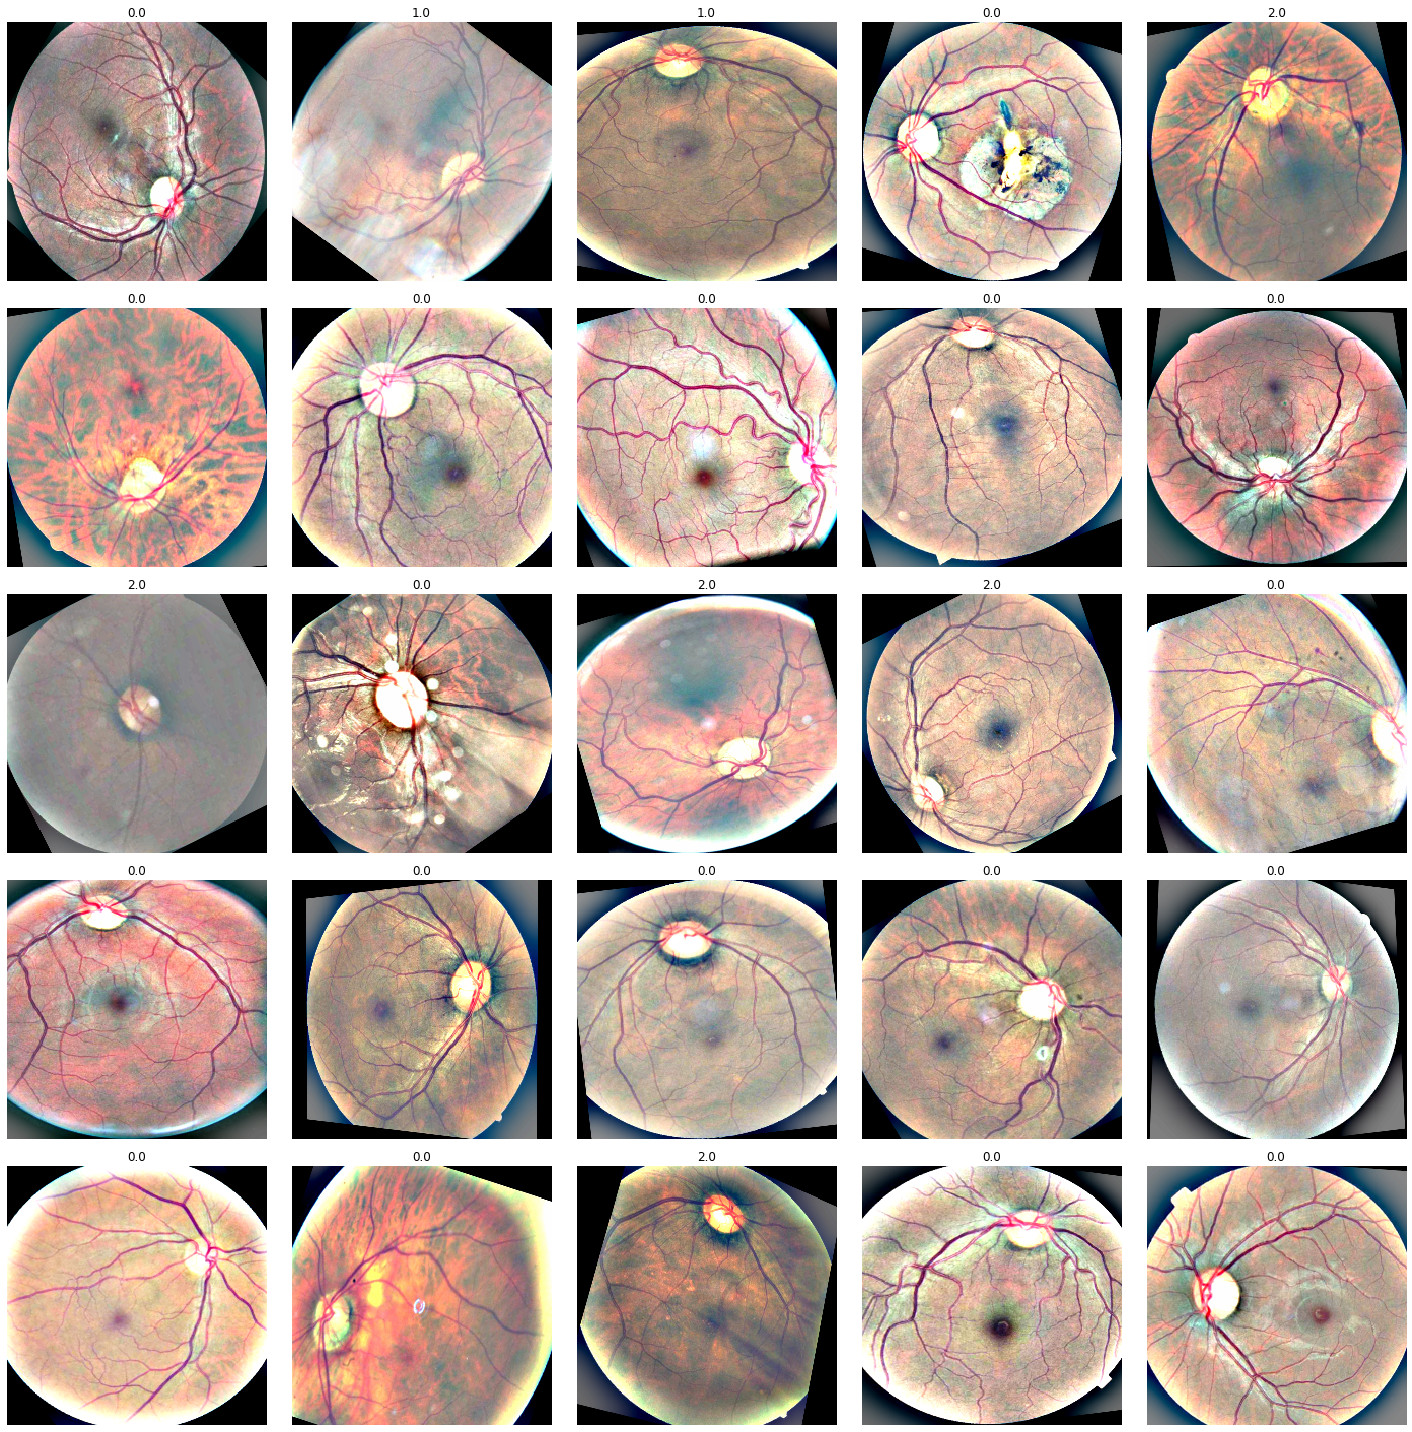

In [14]:
data.show_batch()

# Training (Transfer learning)

The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [15]:
def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

**Training:**

Pretrain on augemented data first, take whole competition data as validation set

## ig_resnext101_32x8d_wsl

In [32]:
model_name = "resnext101_32x8d_wsl"

In [26]:
learn = cnn_learner(data, base_arch=md.resnext101_32x8d, metrics = [qk],
                   callback_fns=[partial(EarlyStoppingCallback, monitor="qk", min_delta=0, patience=3)],
                   model_dir = '../output/models/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 6.92E-03


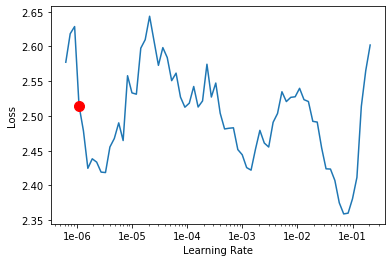

In [27]:
# # Freeze layers up to the last one, so weights will not be updated.
learn.freeze()
        
# # Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [28]:
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(5, 9e-4)

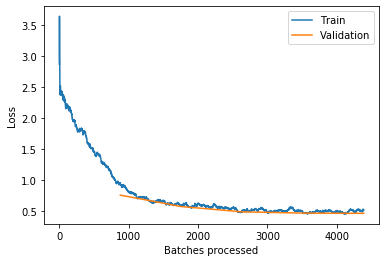

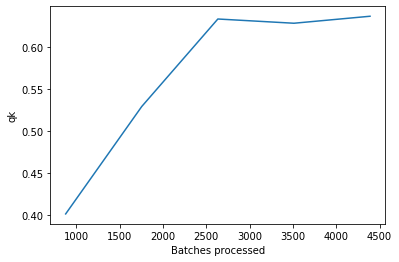

In [29]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.74E-06


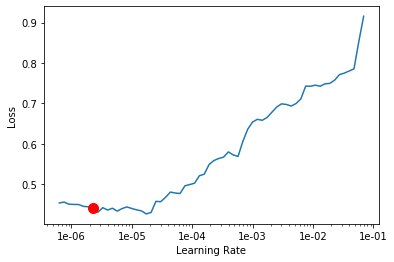

In [30]:
# # Freeze layers up to the last one, so weights will not be updated.
learn.unfreeze()
        
# # Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage1".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(15, max_lr=slice(1e-6, 2e-5), callbacks=[SaveModelCallback(learn, every='improvement', monitor="qk", name=model_save_name)])
print("Model save as:", model_save_name)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Finetune trained model on competition data

In [43]:
data_2019 = (ImageList.from_df(df=df_2019,path='./',cols='path') 
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
data_2019

ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: None

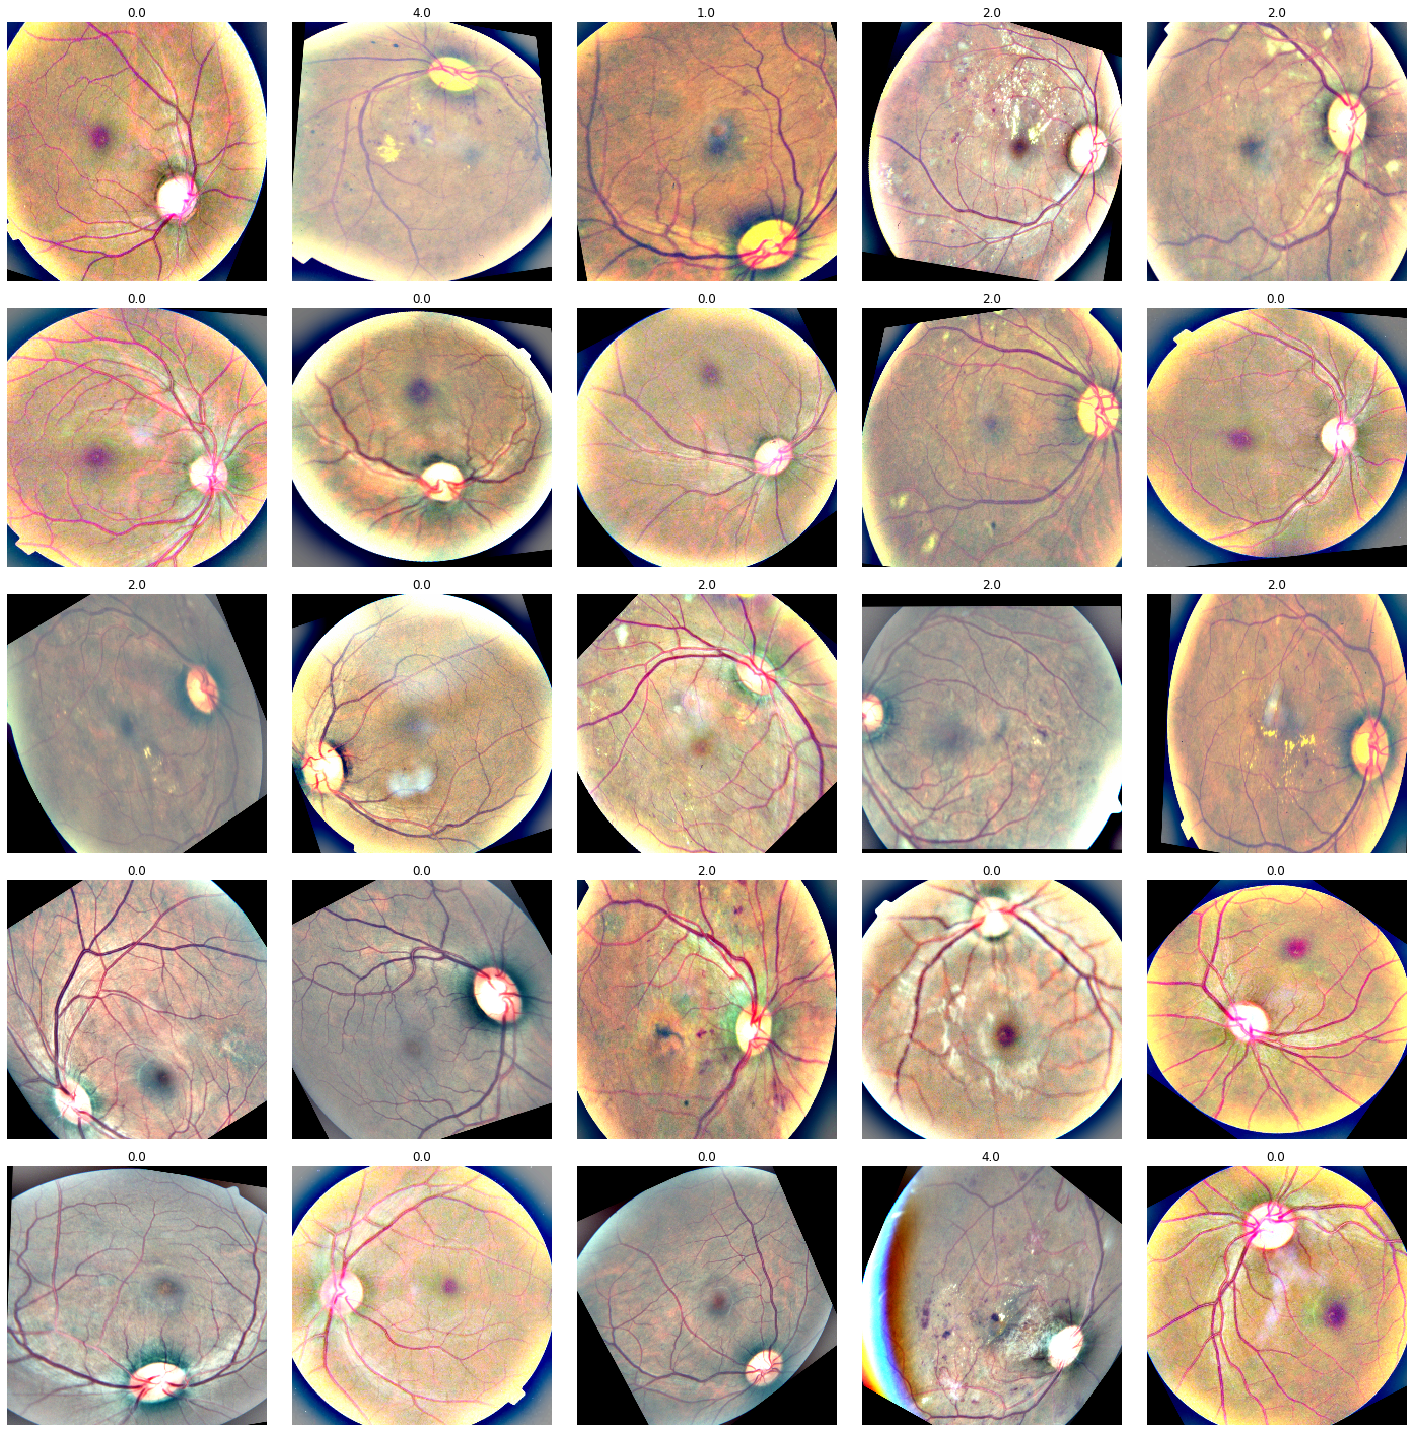

In [42]:
data_2019.show_batch()

In [45]:
learn = cnn_learner(data_2019, base_arch=md.resnext101_32x8d, metrics = [qk],
                   callback_fns=[partial(EarlyStoppingCallback, monitor="qk", min_delta=0, patience=3)],
                   model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing',
                                      suffix='.png'))

In [49]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-03


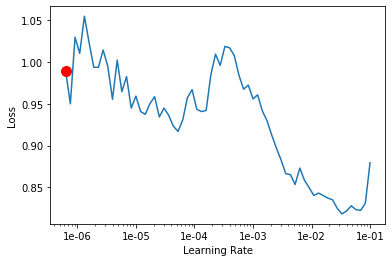

In [47]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [52]:
model_save_name = "{}_{}_stage2".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(5, 2e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor="qk", name=model_save_name)])
print("Model save as:", model_save_name)

Better model found at epoch 0 with qk value: 0.9055102467536926.
Better model found at epoch 1 with qk value: 0.9056335091590881.
Better model found at epoch 4 with qk value: 0.9094372391700745.
Better model found at epoch 5 with qk value: 0.913702130317688.
Epoch 9: early stopping
Model save as: resnext101_32x8d_wsl_0807_02-23-05_stage2


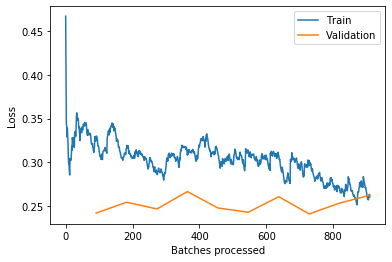

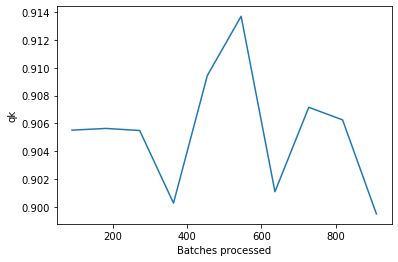

In [53]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [63]:
learn.load(model_save_name)

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,1.0,2.0,1.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 5.25E-06


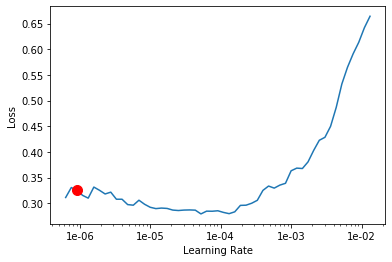

In [64]:
learn.unfreeze()

# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [65]:
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(15, max_lr=slice(1e-6, 1e-4), callbacks=[SaveModelCallback(learn, every='improvement', monitor="qk", name=model_save_name)])
print("Model save as:", model_save_name)

Better model found at epoch 0 with qk value: 0.9006558060646057.
Better model found at epoch 1 with qk value: 0.9111997485160828.
Better model found at epoch 3 with qk value: 0.9138869047164917.
Epoch 7: early stopping
Model save as: resnext101_32x8d_wsl_0807_02-23-05_stage2


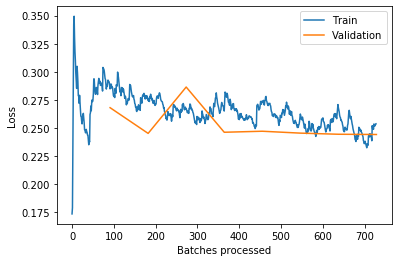

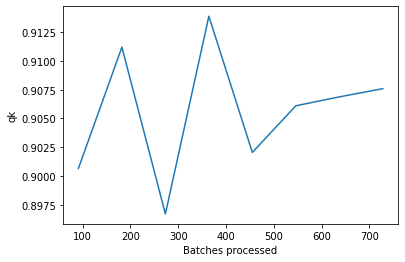

In [66]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [55]:
import scipy as sp

In [56]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [67]:
# Return predictions and targets on `ds_type` dataset.
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)

0.9217330629859529
[0.542188 1.514063 2.359375 3.467188]


In [58]:
# optR.fit(valid_preds[0],valid_preds[1])

# Submission

In [73]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

In [69]:
save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

resnext101_32x8d_wsl_0807_02-23-05_stage2_submition.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49cfe0b4a8>]], dtype=object)

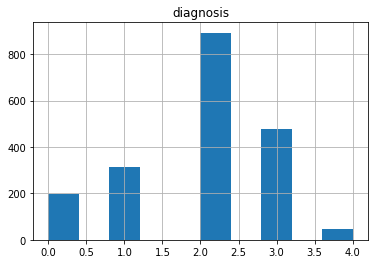

In [70]:
test_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f490436e748>]], dtype=object)

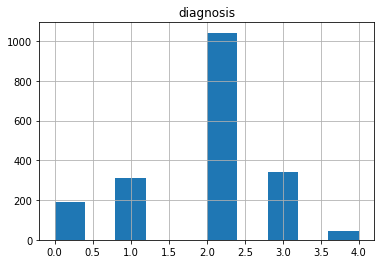

In [74]:
test_df.hist()